In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft
from scipy import signal

# Constants

# Unversal constatns

In [3]:
# #Speed of light
# c = 299792458
# # chirp sequence frequency
# f_chirp = 50*1e3 #Hz

# f0 = 24028e6 # Start Frequency
# f_R = 24.125e9 # freq radar
# wave_length = c/f_R

# # ramp frequency
# f_B = 194e6 # Sweep Bandwidth
# T_r = 1/f_chirp # duration of one cycle
# m_w = f_B/T_r

# n_r = 260 # number of chirps
# T_M = T_r*n_r # duration of one frame

# v = 10 # 2 m/s
# r = 100 # 100m distance


# f_s = 50e6

In [4]:
#Speed of light
c = 299792458
# chirp sequence frequency
f_chirp = 1 #Hz

f0 = 1 # Start Frequency
f_R = 5 # freq radar
wave_length = c/f_R

# ramp frequency
f_B = 500 # Sweep Bandwidth
T_r = 1/f_chirp # duration of one cycle
m_w = f_B/T_r

n_r = 260 # number of chirps
T_M = T_r*n_r # duration of one frame

v = 10 # 2 m/s
r = 100 # 100m distance



f_s = 4000

In [5]:
#angular frequency
w_0 = 2*np.pi*(f0)

# Dopper frequency
f_D = 2*v/wave_length #We assume no relavtive angle
w_D = 2*np.pi*f_D 

## Radar constants

# Functions

In [8]:
from numpy import argmax


def fft_filter(data, sample_period):
    """
    This function takes a data matrix and filters it with a frequency range.
    :param data:
    :param sample_period:
    :param freq_range:
    :return:
    """

    # Generate frequency axis and take FFT
    spectrum = np.fft.fft(data, 256)  # takes FFT of all channels withe zero padding
    spectrum = np.trim_zeros(spectrum, trim='fb')
    
    
    power_spectrum = 20*np.log10(np.abs(spectrum))
    num_of_samples = data.shape[0]  # returns shape of matrix
   
   
    freq = np.fft.fftfreq(n=len(power_spectrum),d=sample_period)
    
    freq = np.fft.fftshift(freq)
    power_spectrum = np.fft.fftshift(power_spectrum)
    print(freq[argmax(power_spectrum)])
    
    return power_spectrum, freq

# TX

$$
\begin{align}
s(t) = Acos[w_0t + \theta(t) + \phi_0 ] \\
\end{align}
$$

$$
w_0 = 2\pi f_0
$$ 
where $f_0$ is the start frequency of the chirp


LFM up-chrip instentaneous phase
$$
\theta(t) = 2 \pi (f_0 t+ \frac{\mu}{2}t^2)
$$

where μ  =  (2 π B )/ τ  is the LFM coefficient

$\tau$ is the chirp duration

Lets rewrite it to domyjing that makes sense.....

$$
\theta(t) =  w_0t+ \pi \mu t^2
$$

And lets include $ \mu $

$$
\theta(t) =  w_0t+ 2\pi^2 \frac{ B}{ \tau} t^2
$$

In [9]:
def up_chirp(t, w0, f_B, T_r):
    """
    Returns the up chirp signal
    """
    mu =2*np.pi *f_B / T_r
    
    return w0*t + np.pi*mu*t**2

Thius gives us the full expression for the TX

$$
\begin{align}
s(t)_{tx} = A_{tx}cos[2w_0t + \pi \frac{ B}{ \tau} t^2 + \phi_0 ] \\
\end{align}
$$

In [10]:
def tx_signal_2(t, w0, f_B, T_r):
    """
    Returns the tx signal
    """
    return np.cos(w0*t +up_chirp(t, w0, f_B, T_r))

Thus the instantanius frequency is

$$
f(t) = f_0 + \mu t
$$

In [35]:
t = np.linspace(0, T_r, int(f_s))
print(len(t))
signal_TX= tx_signal_2(t, w_0, f_B, T_r)

4000


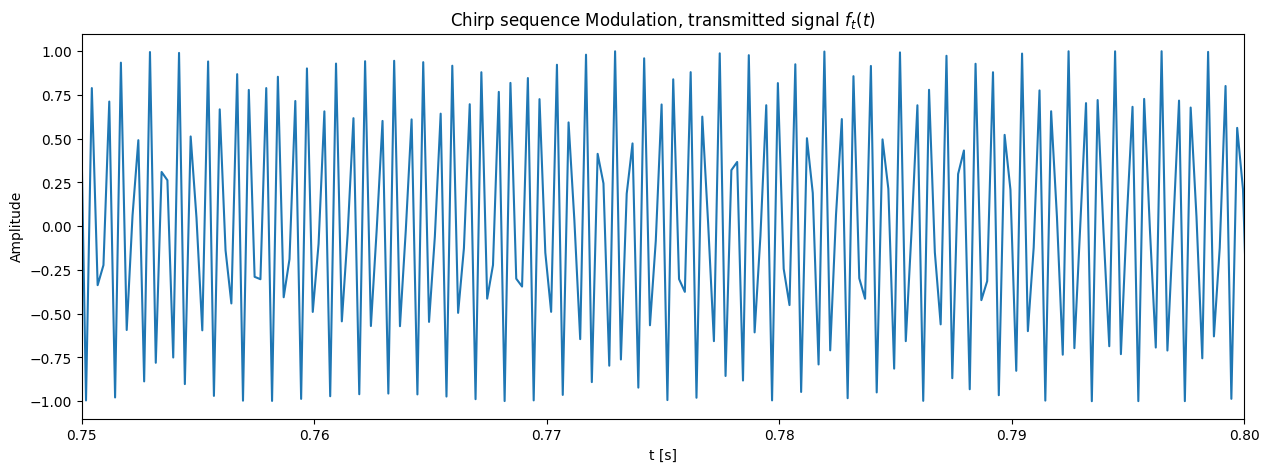

In [38]:
plt.figure(figsize=(15,5))
plt.plot(t, signal_TX)
plt.xlim(0.75*T_r, 0.8*T_r)
plt.xlabel("t [s]")
plt.ylabel("Amplitude")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

plt.show()

In [39]:
def freq_to_range(f):
    m_w = f_B/T_r
    return f*c/(2*m_w)

In [40]:
freq_to_range(4000)

1199169832.0

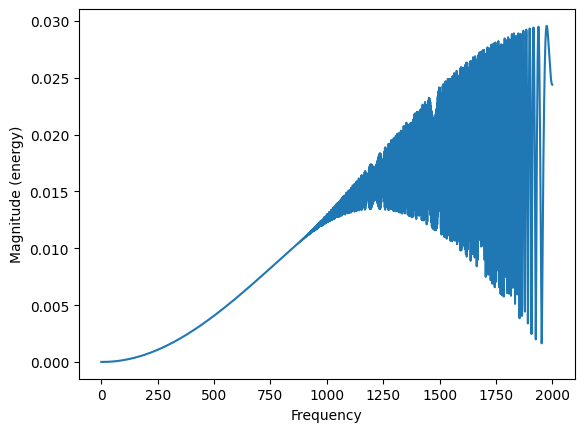

In [13]:
plt.magnitude_spectrum(signal_TX, Fs=f_s, )
plt.show()

Lets verdyfy that its a chirp

In [14]:
def plot_spectrogram(title, w, fs):
    ff, tt, Sxx = signal.spectrogram(w, fs=fs,nperseg=256)
    
    plt.figure(figsize=(15,5))
    plt.pcolormesh(tt, ff, Sxx, cmap='gray_r', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()

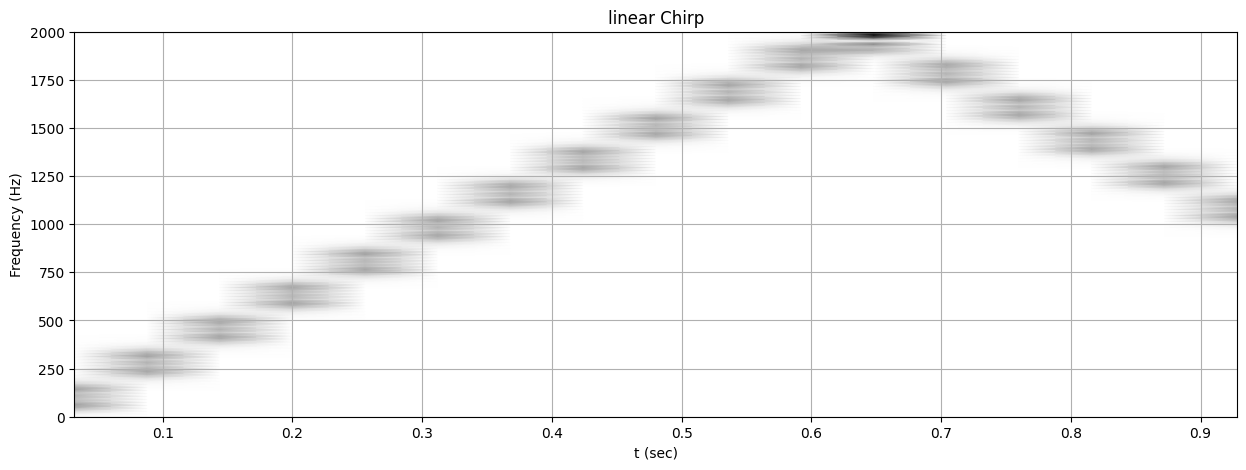

In [15]:
plot_spectrogram(f'linear Chirp', signal_TX, f_s)
plt.show()


-46.875


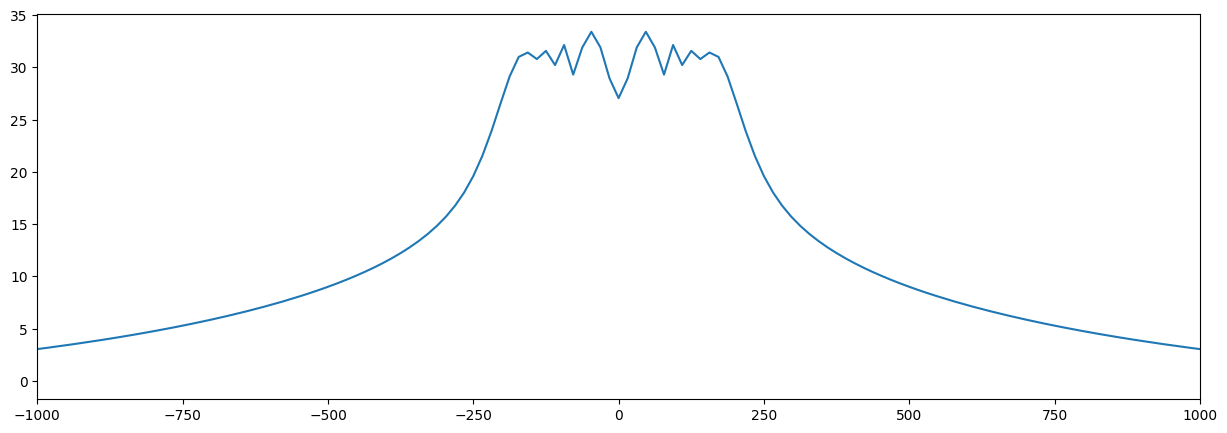

In [16]:
#FFT
power_spectrum, freq = fft_filter(signal_TX, 1/f_s)
plt.figure(figsize=(15,5))
plt.xlim(-1000, 1000)
plt.plot(freq, power_spectrum)
plt.show()

In [17]:
def tx(t, w0, w1, t0, t1):
    """Linear sawtooth FMCW signal.
    p24
    
    Args:
        t: time
        w0: start andular frequency
        w1: end angular frequency
        t0: start time
        t1: end time
    
    Returns:
        signal
    """
    ramp = 2*np.pi(f_0)
    return np.cos(w0*t + (w1-w0)/(t1-t0)*(t-t0)**2/2)

# RX


The RX signal is the given by

$$
\begin{align}
s(t)_{rx} = A_{rx}cos[2(w_0+w_D)(t-t_d)t + \pi \frac{ B}{ \tau} (t-t_d)^2 + \phi_0 ] \\
\end{align}
$$

In [18]:
def rx_signal(t, w0, f_B, T_r, w_D, t_delay):
    """
    Returns the rx signal
    """
    return np.cos(2*(w0+w_D)*(t-t_delay) +up_chirp((t-t_delay), (w0+w_D) , f_B, T_r))

In [19]:
t = np.linspace(0, T_M, int(T_M*f_s))
signal_rx = rx_signal(t, w_0, f_B, T_r, w_D, 2*r/c)

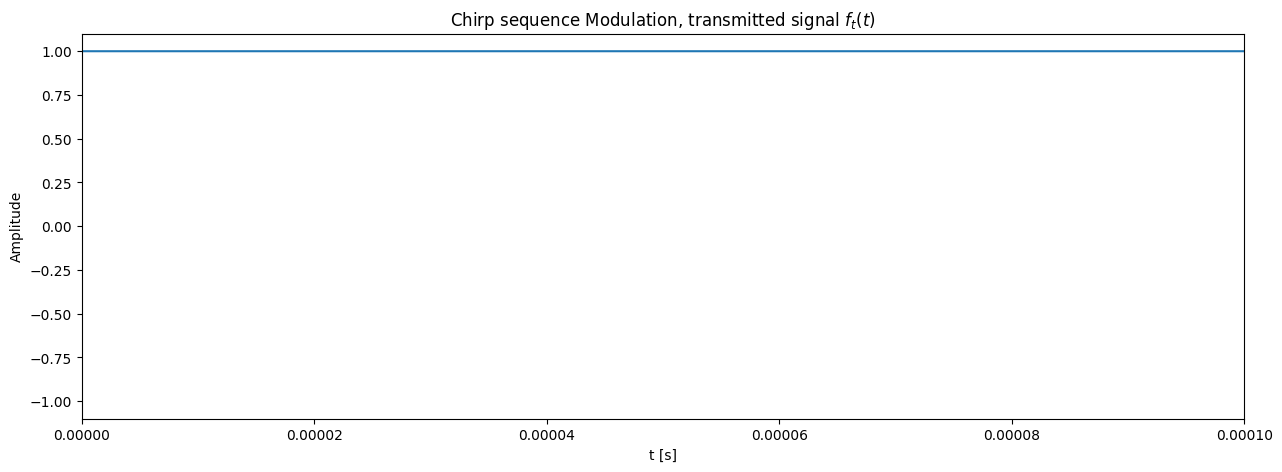

In [20]:
plt.figure(figsize=(15,5))
plt.plot(t, signal_rx)
plt.xlim(0, 1*1e-4)
plt.xlabel("t [s]")
plt.ylabel("Amplitude")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

plt.show()

# Mixing
TODO

# Output after filtering

$$
\begin{align}
s(t) = 1/2 \left[ A_{t} cos[w_0 t_d - w_D(t-t_d)+ \theta (t) -\theta (t-t_d) ] +A_{t} cos[w_0 t + (w_0+w_D)(t-t_d)+ \theta (t) +\theta (t-t_d)] \right]
\end{align}
$$

Lets rewrite it to domyjing that makes sense.....

lets split it in two parts

$$
\begin{align}
A_{t} cos[w_0 t_d - w_D(t-t_d)+ w_0t+ \pi \frac{ B}{ \tau} t^2 -(w_0(t-t_d)+ \pi \frac{ B}{ \tau} (t-t_d)^2) ]
\end{align}

$$


$$
\begin{align}
A_{t} cos[w_0 t + (w_0+w_D)(t-t_d)+ w_0t+ \pi \frac{ B}{ \tau} t^2 +w_0(t-t_d)+ \pi \frac{ B}{ \tau} (t-t_d)^2]
\end{align}
$$


Lets simplify these equations
Starting with the first

$$
\begin{align}
A_{t} cos[w_0 t_d - w_Dt-w_Dt_d+ w_0t+ \pi \frac{ B}{ \tau} t^2 -w_0t+w_0t_d- \pi \frac{ B}{ \tau} (t-t_d)^2) ]
\end{align}

$$

source p24

$$
\begin{align}
s(t) = 1/2 \left[ A_{tx}cos[2w_0t + \pi \frac{ B}{ \tau} t^2 + \phi_0 ] + A_{rx}cos[2(w_0+w_D)(t-t_d)t + \pi \frac{ B}{ \tau} (t-t_d)^2 + \phi_0 ] \right] \\
\end{align}
$$

In [21]:
def output_signal(t, w0, f_B, T_r, w_D, t_delay):
    """
    Returns the output signal
    """
    theta_0 = up_chirp(t, w0, f_B, T_r)
    theta_D = up_chirp((t-t_delay),(w_0+ w_D),f_B, T_r)
    return 0.5*(np.cos(w_0*t_delay -w_D*(t-t_delay)+theta_0-theta_D) + np.cos(w_0*t -(w_0+w_D)*(t-t_delay)+theta_0+theta_D))
    return tx_signal(t, w0, f_B, T_r)*rx_signal(t, w0, f_B, T_r, w_D, t_delay)
    

In [22]:
t = np.linspace(0, T_M, int(T_M*f_s))
signal_out = output_signal(t, w_0, f_B, T_r, w_D, r/c)

In [23]:
signal_out

array([ 1.        ,  0.99999522,  0.99996856, ..., -0.20964634,
       -0.21690069,  0.3150472 ])

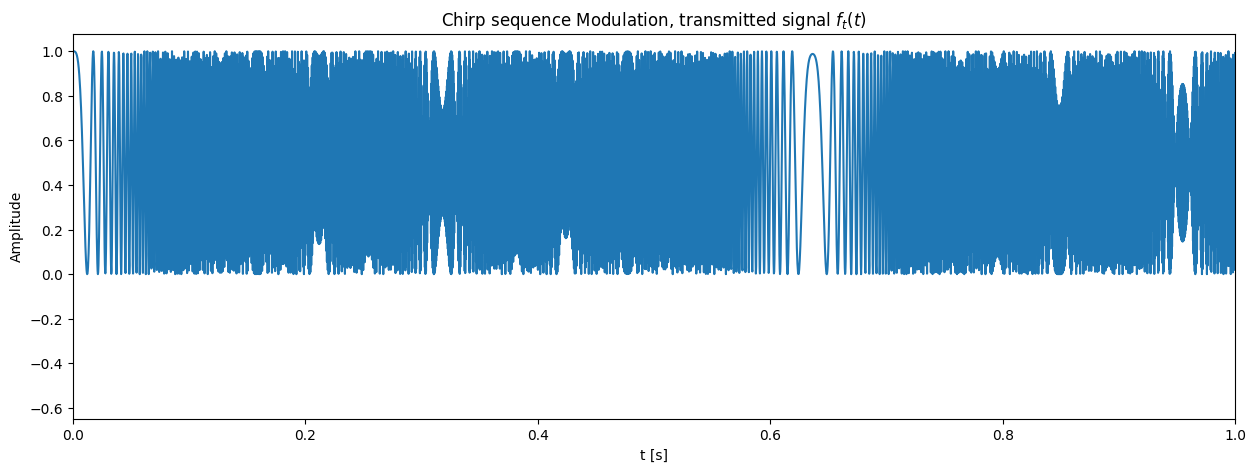

In [24]:
plt.figure(figsize=(15,5))
plt.plot(t, signal_out)
plt.xlim(0, T_r)
plt.xlabel("t [s]")
plt.ylabel("Amplitude")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

plt.show()

# FFt

0.0


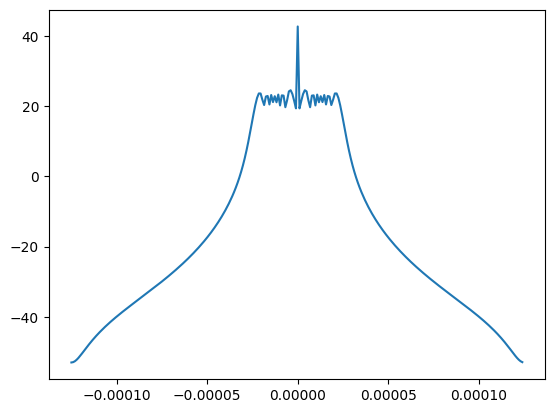

In [25]:
power_spectrum_2, freq_2 = fft_filter(signal_out, f_s)
plt.figure()
plt.plot(freq_2,power_spectrum_2)
#plt.xlim(-100000,100000)
#plt.ylim(0,50)
plt.show()

# Linear sawtooth FMCW

p.20

In [26]:
def saw_signal(t, w0, w1, t0, t1):
    """Linear sawtooth FMCW signal.
    
    Args:
        t: time
        w0: start andular frequency
        w1: end angular frequency
        t0: start time
        t1: end time
    
    Returns:
        signal
    """
    return np.cos(w0*t + (w1-w0)/(t1-t0)*(t-t0)**2/2)
    return np.cos(2*np.pi*f0*t + (f1-f0)/(t1-t0)*t**2/2)
    return np.cos(2*np.pi*(f0*(t-t0) + (f1-f0)*(t-t0)**2/(2*(t1-t0))))

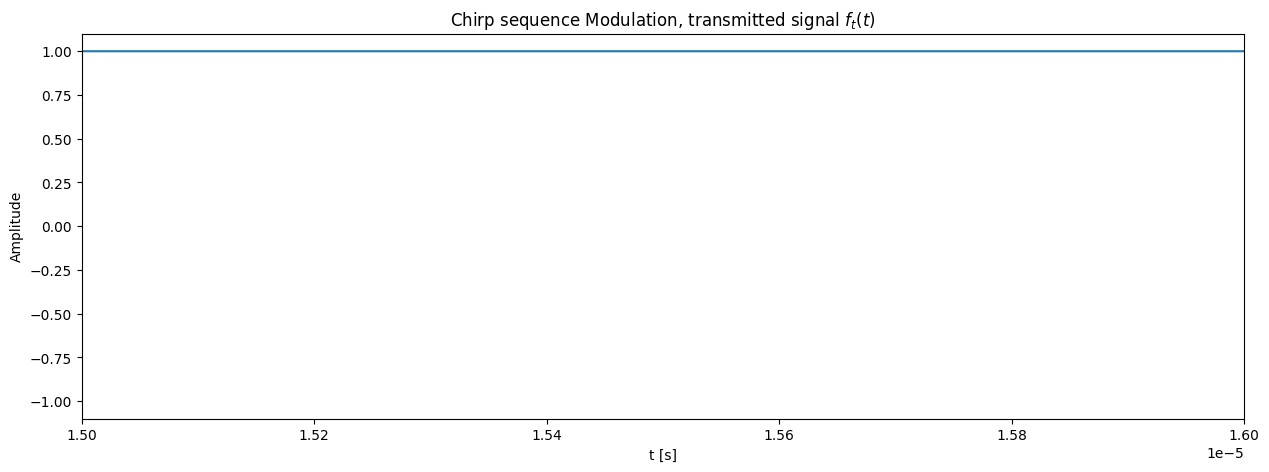

In [27]:
# chirp sequence
t = np.linspace(0, T_M, int(T_M*f_s))
f0 = 77e9
f1 = 81e9
w0 = 2*np.pi*f0
w1 = 2*np.pi*f1
chirp = saw_signal(t, w0, w1, 0, T_M)
plt.figure(figsize=(15,5))
plt.plot(t, chirp)
plt.xlim(15*1e-6, 16*1e-6)
plt.xlabel("t [s]")
plt.ylabel("Amplitude")
plt.title("Chirp sequence Modulation, transmitted signal $f_t(t)$");

plt.show()

In [28]:
#Using scipy to calculate the chirp sequence
t = np.linspace(0, T_r, 1500)
w = signal.chirp(t, f0, T_r, f0+f_B, method='linear')



In [29]:
print(f0,f0+f_B)
print(f_B/2)
print(f0+f_B/2)

77000000000.0 77000000500.0
250.0
77000000250.0


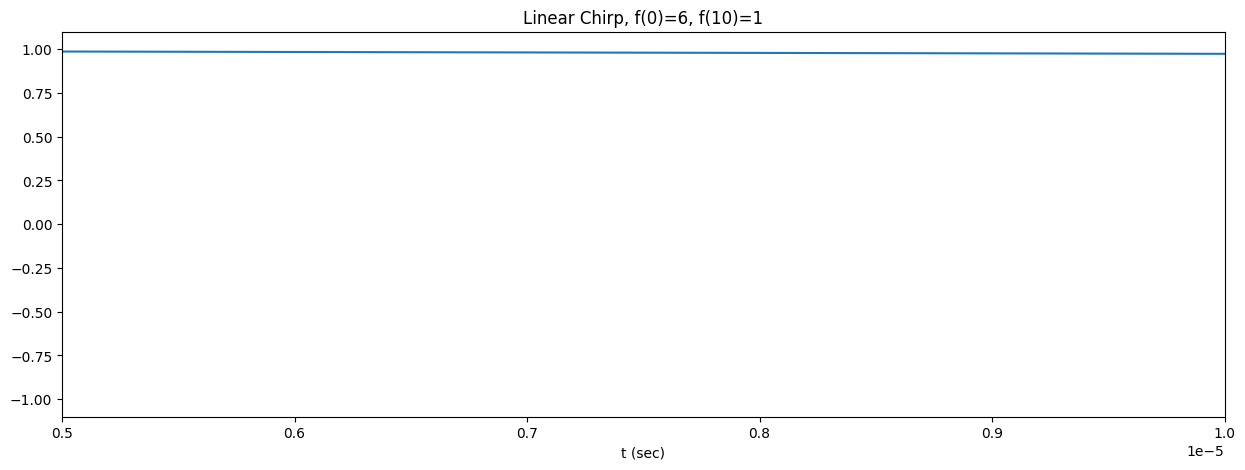

In [30]:
plt.figure(figsize=(15,5))
plt.plot(t, w)
plt.title("Linear Chirp, f(0)=6, f(10)=1")
plt.xlabel('t (sec)')
plt.xlim(0.5e-5, 1*1e-5)

plt.show()

0.4296875


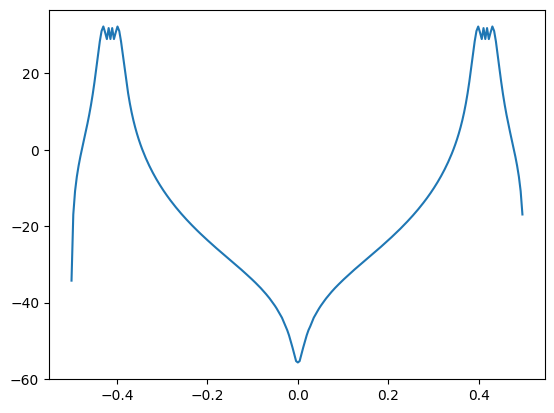

In [31]:
power_spectrum_2, freq_2 = fft_filter(w, 1)
plt.figure()
plt.plot(freq_2,power_spectrum_2)
#plt.xlim(-100000,100000)
#plt.ylim(0,50)
plt.show()

## Recived signal

In [32]:
#Doopler shift
f_D = 2*m_w*c/(2*np.pi)

    
    



In [33]:
v = 50/3.6 # 50km/h
r = 100 # 100m distance